In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from scipy.stats import probplot
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']


Mounted at /drive


In [4]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20))

del raw22
del raw21
del raw20
del raw23

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False, dtype = int)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False, dtype = int)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR_bool'] = pit_hand['R']
all_data['bat_handR_bool'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#define hit direction type
all_data['is_oppo'] = 0
all_data.loc[all_data.hit_direction > 0, 'is_oppo'] = 1
all_data['is_pull'] = 1-all_data.is_oppo.values

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)
all_data['batter_id_hand_bool'] = all_data.batter.astype(str) + '-' + all_data.bat_handR_bool.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'sz_top', 'sz_bot', 'batter_id_hand', 'batter_id_hand_bool', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
                     'release_spin_rate', 'release_extension', 'pitcher',  'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR','pit_handR_bool', 'bat_handR_bool',  'x', 'y', 'hit_direction', 'hd', 'is_pull', 'is_oppo']]

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

all_data = all_data.merge(batter_indices, on = 'batter_id_hand')

### Model

In [5]:
#convert movement from feet to inches
all_data[['mx', 'mz']] = all_data[['pfx_x', 'pfx_z']].values * 12

#standardize these pitch variables
features = ['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'pit_handR', 'bat_handR', 'batter_index']
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction']].values)
all_data[['plate_x_ft', 'plate_z_ft']] = all_data[['plate_x', 'plate_z']].values
all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction']].values)

In [6]:
#train test split
train = all_data.loc[all_data.game_year < 2023]
test = all_data.loc[all_data.game_year == 2023]

In [7]:
#data set class
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

train_x = train[features].values
train_y = train.launch_angle.values
test_x = test[features].values
test_y = test.launch_angle.values
trainset = DataSet(train_x, train_y)
testset = DataSet(test_x, test_y)

#data loaders
trainloader = DataLoader(trainset, batch_size =128, shuffle = True)
testloader = DataLoader(testset, batch_size = 128, shuffle = True)

In [8]:
embedding_size = 15

class LA(nn.Module):
  def __init__(self):
      super(LA, self).__init__()

      self.batter_embedding = nn.Embedding(num_embeddings = batter_indices.shape[0], embedding_dim = embedding_size)
      self.batter_embedding.weight.data.fill_(.1)
      self.l1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
      self.l2 = nn.Linear(in_features = 128, out_features = 128)
      self.l3 = nn.Linear(128, 64)
      self.l4 = nn.Linear(64, 32)
      self.relu = nn.ReLU()
      self.mean_layer1 = nn.Linear(32,1)
      self.std_layer1 = nn.Linear(32,1)

  def forward(self, x):
      batter_idx = x[:,-1].int()
      bat_emb = self.batter_embedding(batter_idx)

      conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
      o = self.relu(self.l1(conc))
      o = self.relu(self.l2(o))
      o = self.relu(self.l3(o))
      o = self.relu(self.l4(o))

      #mean: add the output to the pymc mean
      mean = self.mean_layer1(o)
      #stddev
      stddev = self.relu(self.std_layer1(o)) + 1

      return mean, stddev

In [9]:
def gaussianloss(m, target, st):
  dist = torch.distributions.normal.Normal(loc = m.squeeze(1), scale = st.squeeze(1))
  return -1*torch.mean(dist.log_prob(target))

In [10]:
#train
learning_rate = 1e-3
epochs = 25
model = LA().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
loss_fn = gaussianloss
train_losses = []
test_losses = []

In [11]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        mean, s = model(x)
        #calculate loss
        loss = loss_fn(mean, y_truth, s)
        loss_val += loss.item()

        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))

    loss_val = 0
    for batch, (x, y_truth) in enumerate(testloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        m, s = model(x)

        #loss
        loss = loss_fn(m, y_truth, s)
        loss_val += loss.item()
    test_losses.append(loss_val/ len(testloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/25, loss = 4.990778
epoch : 2/25, loss = 4.707850
epoch : 3/25, loss = 4.705256
epoch : 4/25, loss = 4.703410
epoch : 5/25, loss = 4.701713
epoch : 6/25, loss = 4.699859
epoch : 7/25, loss = 4.697527
epoch : 8/25, loss = 4.693452
epoch : 9/25, loss = 4.683183
epoch : 10/25, loss = 4.656484
epoch : 11/25, loss = 4.634106
epoch : 12/25, loss = 4.620783
epoch : 13/25, loss = 4.609831
epoch : 14/25, loss = 4.600182
epoch : 15/25, loss = 4.591530
epoch : 16/25, loss = 4.585048
epoch : 17/25, loss = 4.580680
epoch : 18/25, loss = 4.577057
epoch : 19/25, loss = 4.573417
epoch : 20/25, loss = 4.568979
epoch : 21/25, loss = 4.563528
epoch : 22/25, loss = 4.556502
epoch : 23/25, loss = 4.549503
epoch : 24/25, loss = 4.544513
epoch : 25/25, loss = 4.541303


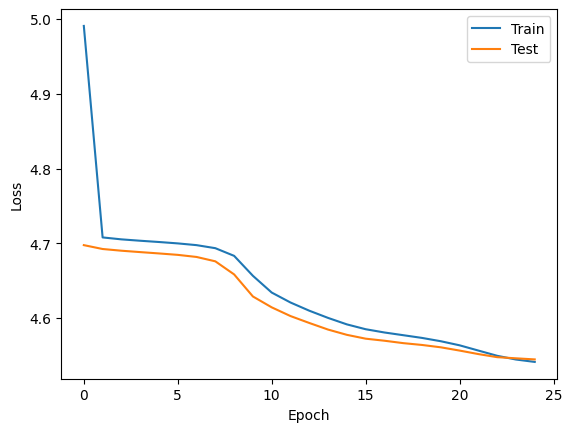

In [12]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing and comparing to old model

In [13]:
#read in the old pymc launch angle dists
pymc_effects = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/launch_angle/la_dists_sloan_version_testing.csv')
train = train.merge(pymc_effects[['batter_id_hand', 'batter_mean_pull', 'batter_mean_oppo', 'batter_sigma_pull', 'batter_sigma_oppo']], right_on = 'batter_id_hand', left_on = 'batter_id_hand_bool')
test = test.merge(pymc_effects[['batter_id_hand', 'batter_mean_pull', 'batter_mean_oppo', 'batter_sigma_pull', 'batter_sigma_oppo']], right_on = 'batter_id_hand',  left_on = 'batter_id_hand_bool')

In [14]:
#old log like
train['old_la_mean'] = train.is_pull.values * train.batter_mean_pull.values + train.is_oppo.values * train.batter_mean_oppo.values
train['old_la_std'] = train.is_pull.values * train.batter_sigma_pull.values + train.is_oppo.values * train.batter_sigma_oppo.values
test['old_la_mean'] = test.is_pull.values * test.batter_mean_pull.values + test.is_oppo.values * test.batter_mean_oppo.values
test['old_la_std'] = test.is_pull.values * test.batter_sigma_pull.values + test.is_oppo.values * test.batter_sigma_oppo.values
train['old_log_like'] = norm(loc = train.old_la_mean.values, scale = train.old_la_std.values).logpdf(train.launch_angle.values)
test['old_log_like'] = norm(loc = test.old_la_mean.values, scale = test.old_la_std.values).logpdf(test.launch_angle.values)

In [15]:
#calculate log liklihoods with nnet
mu, var = model(torch.tensor(train[features].values, dtype = torch.float32).to(device))
train['m'] = mu.detach().cpu().numpy()
train['s'] = var.detach().cpu().numpy()

mu, var = model(torch.tensor(test[features].values, dtype = torch.float32).to(device))
test['m'] = mu.detach().cpu().numpy()
test['s'] = var.detach().cpu().numpy()

train['log_like'] = norm(loc = train.m.values, scale = train.s.values).logpdf(train.launch_angle.values)
test['log_like'] = norm(loc = test.m.values, scale = test.s.values).logpdf(test.launch_angle.values)

In [16]:
#compare log likelihood on train set
train.old_log_like.mean(), train.log_like.mean()

(np.float64(-4.661184869048309), np.float64(-4.53910028382863))

In [17]:
#test set comp
test.old_log_like.mean(), test.log_like.mean()

(np.float64(-4.666358730139081), np.float64(-4.544409150459712))

Based on log likelihood, the neural network fits the training data and testing data better than the pymc distributions

In [18]:
#draw a sample for each launch angle in the datasets using the neural net
train['samples'] = norm(loc = train.m.values, scale = train.s.values).rvs()
test['samples'] = norm(loc = test.m.values, scale = test.s.values).rvs()
#now with the pymc dists
train['old_samples'] = norm(loc = train.old_la_mean.values, scale = train.old_la_std.values).rvs()
test['old_samples'] = norm(loc = test.old_la_mean.values, scale = test.old_la_std.values).rvs()

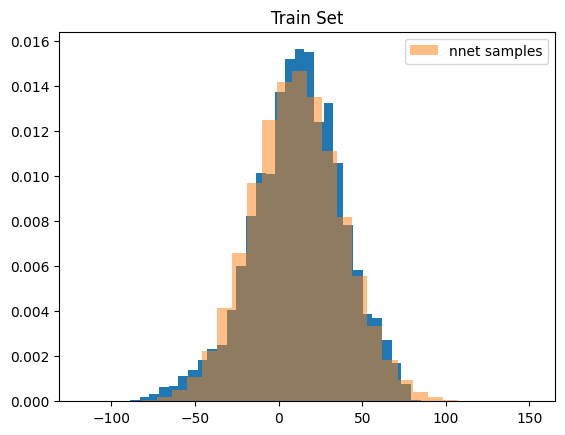

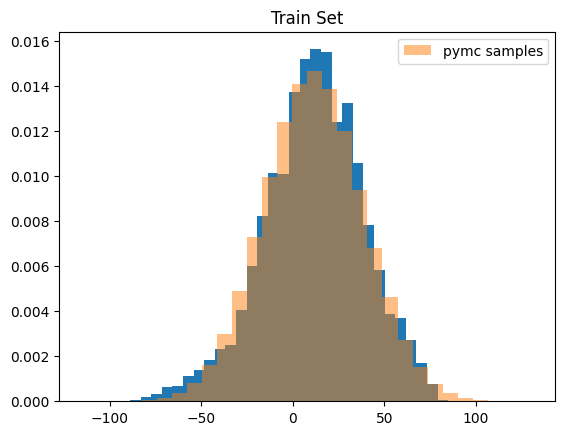

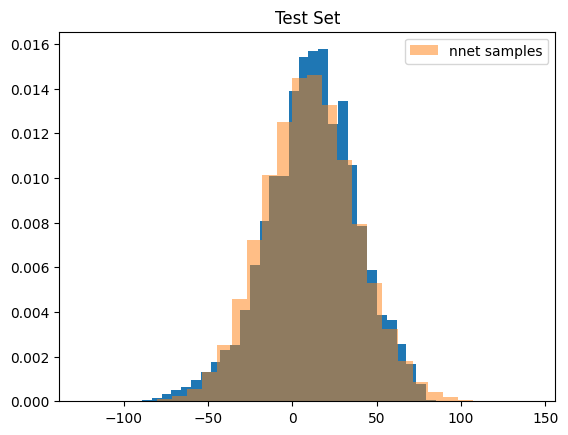

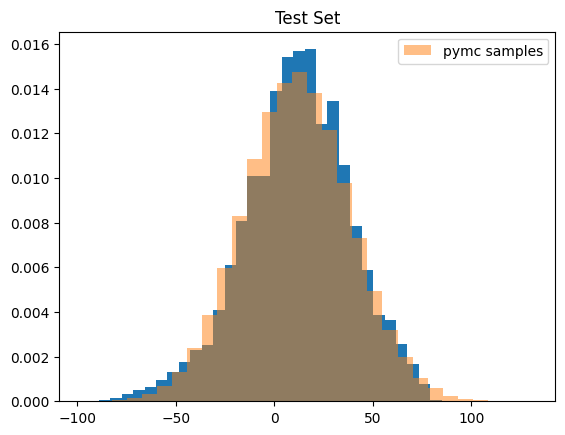

In [19]:
#compare the samples with the actual launch angles
plt.hist(train.launch_angle.values, density = True, bins = 30)
plt.hist(train.samples.values, density = True, bins = 30, alpha = 0.5, label = 'nnet samples')
plt.legend()
plt.title('Train Set')
plt.show()

plt.hist(train.launch_angle.values, density = True, bins = 30)
plt.hist(train.old_samples.values, density = True, bins = 30, alpha = 0.5, label = 'pymc samples')
plt.legend()
plt.title('Train Set')
plt.show()

plt.hist(test.launch_angle.values, density = True, bins = 30)
plt.hist(test.samples.values, density = True, bins = 30, alpha = 0.5, label = 'nnet samples')
plt.legend()
plt.title('Test Set')
plt.show()

plt.hist(test.launch_angle.values, density = True, bins = 30)
plt.hist(test.old_samples.values, density = True, bins = 30, alpha = 0.5, label = 'pymc samples')
plt.legend()
plt.title('Test Set')
plt.show()

In [20]:
#one thing I noticed in the eda notebook is that launch angle is largely a function of pitch height (low or high), so let's see if the neural net figured that out
train['mid_sz'] = (train.sz_top.values + train.sz_bot.values) / 2
test['mid_sz'] = (test.sz_top.values + test.sz_bot.values) / 2
train['is_high'] = 0
train.loc[train.plate_z_ft > train.mid_sz, 'is_high'] = 1
test['is_high'] = 0
test.loc[test.plate_z_ft > test.mid_sz, 'is_high'] = 1

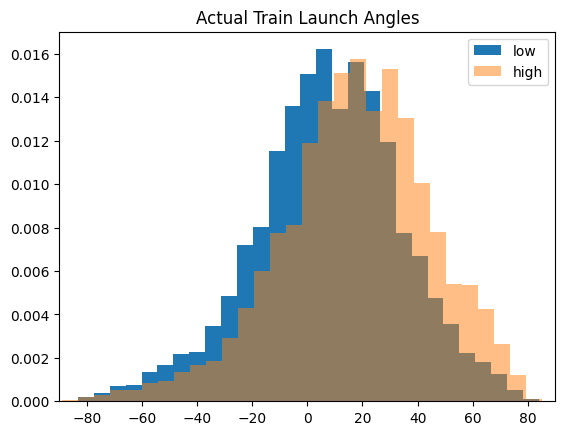

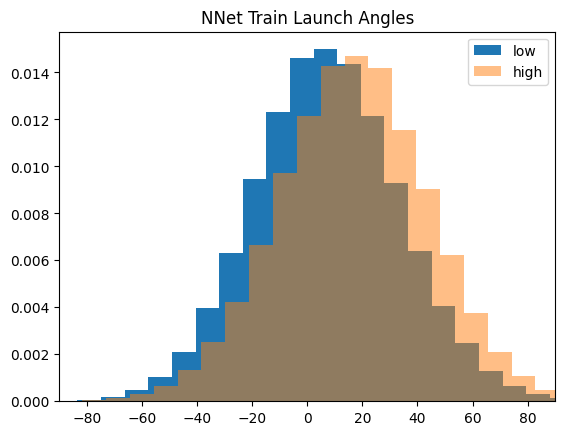

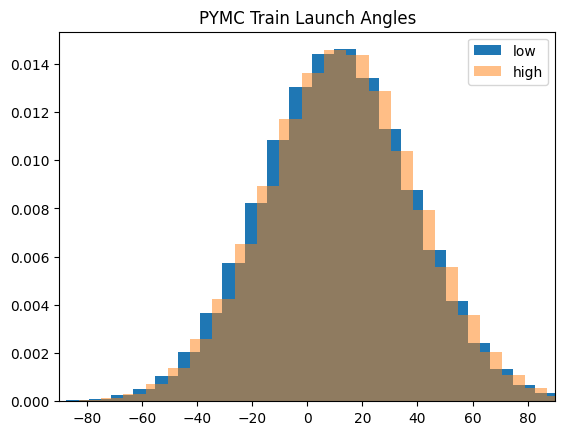

In [21]:
plt.hist(train.loc[train.is_high == 0].launch_angle.values, density = True, bins = 30, label = 'low')
plt.hist(train.loc[train.is_high == 1].launch_angle.values, density = True, bins = 30, label = 'high', alpha = 0.5)
plt.legend()
plt.xlim((-90,90))
plt.title('Actual Train Launch Angles')
plt.show()

plt.hist(train.loc[train.is_high == 0].samples.values, density = True, bins = 30, label = 'low')
plt.hist(train.loc[train.is_high == 1].samples.values, density = True, bins = 30, label = 'high', alpha = 0.5)
plt.legend()
plt.title('NNet Train Launch Angles')
plt.xlim((-90,90))
plt.show()

plt.hist(train.loc[train.is_high == 0].old_samples.values, density = True, bins = 30, label = 'low')
plt.hist(train.loc[train.is_high == 1].old_samples.values, density = True, bins = 30, label = 'high', alpha = 0.5)
plt.legend()
plt.xlim((-90,90))
plt.title('PYMC Train Launch Angles')
plt.show()

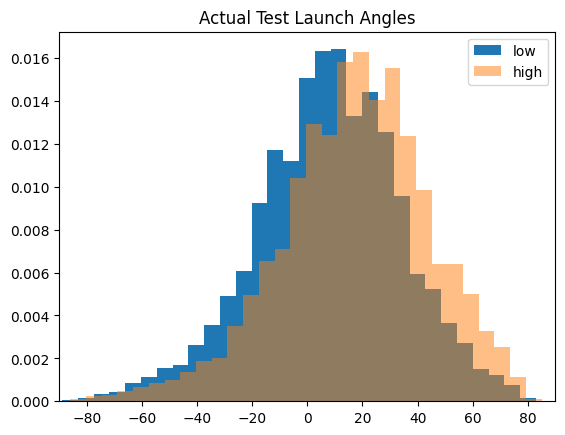

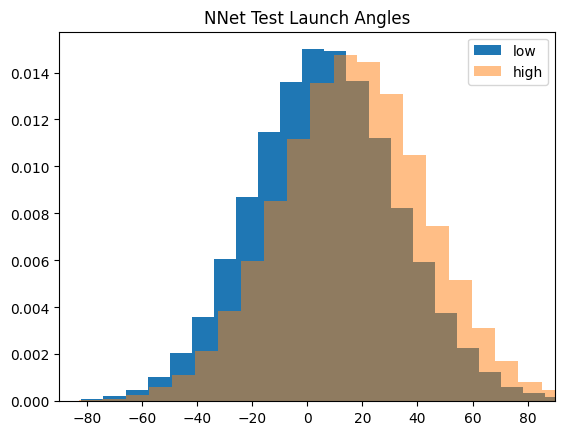

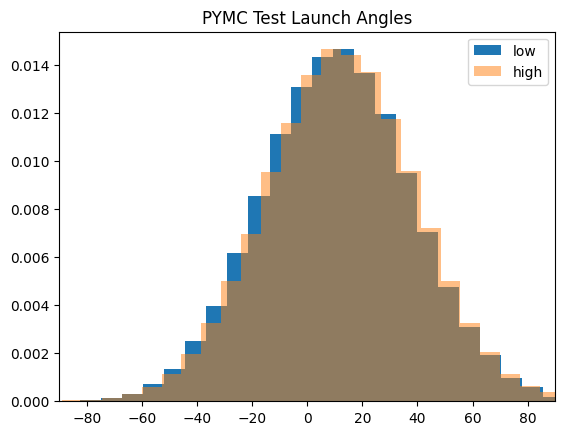

In [22]:
plt.hist(test.loc[test.is_high == 0].launch_angle.values, density = True, bins = 30, label = 'low')
plt.hist(test.loc[test.is_high == 1].launch_angle.values, density = True, bins = 30, label = 'high', alpha = 0.5)
plt.legend()
plt.xlim((-90,90))
plt.title('Actual Test Launch Angles')
plt.show()

plt.hist(test.loc[test.is_high == 0].samples.values, density = True, bins = 30, label = 'low')
plt.hist(test.loc[test.is_high == 1].samples.values, density = True, bins = 30, label = 'high', alpha = 0.5)
plt.legend()
plt.title('NNet Test Launch Angles')
plt.xlim((-90,90))
plt.show()

plt.hist(test.loc[test.is_high == 0].old_samples.values, density = True, bins = 30, label = 'low')
plt.hist(test.loc[test.is_high == 1].old_samples.values, density = True, bins = 30, label = 'high', alpha = 0.5)
plt.legend()
plt.xlim((-90,90))
plt.title('PYMC Test Launch Angles')
plt.show()

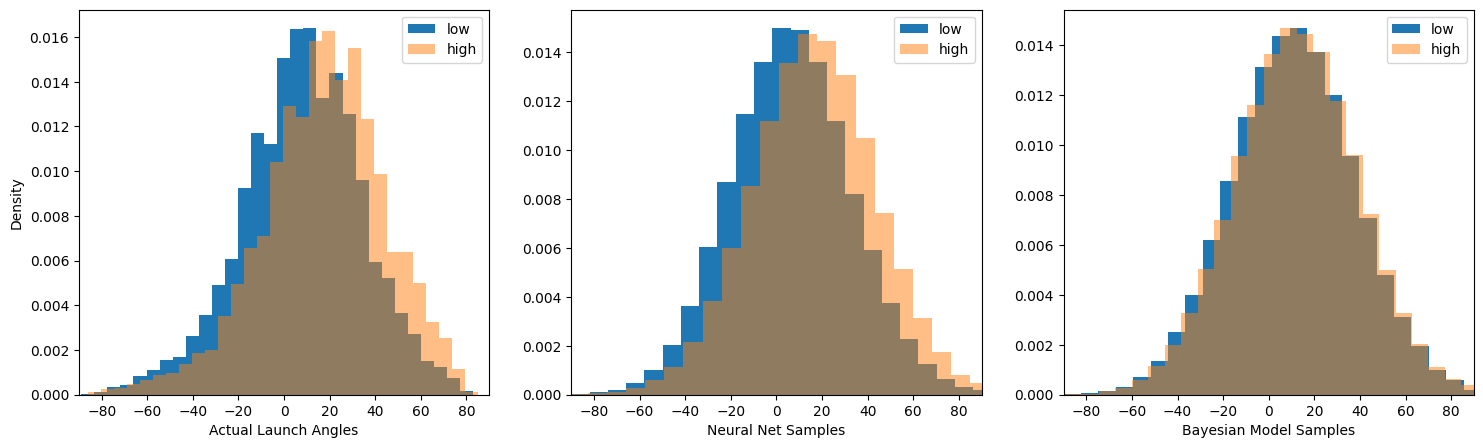

In [23]:
#prettier plot for paper
plt.figure(figsize = (18,5))
ax1 = plt.subplot(131)
ax1.hist(test.loc[test.is_high == 0].launch_angle.values, density = True, bins = 30, label = 'low')
ax1.hist(test.loc[test.is_high == 1].launch_angle.values, density = True, bins = 30, label = 'high', alpha = 0.5)
ax1.legend()
ax1.set_xlim((-90,90))
ax1.set_xlabel('Actual Launch Angles')
ax1.set_ylabel('Density')

ax2 = plt.subplot(132)
ax2.hist(test.loc[test.is_high == 0].samples.values, density = True, bins = 30, label = 'low')
ax2.hist(test.loc[test.is_high == 1].samples.values, density = True, bins = 30, label = 'high', alpha = 0.5)
ax2.legend()
ax2.set_xlim((-90,90))
ax2.set_xlabel('Neural Net Samples')

ax3 = plt.subplot(133)
ax3.hist(test.loc[test.is_high == 0].old_samples.values, density = True, bins = 30, label = 'low')
ax3.hist(test.loc[test.is_high == 1].old_samples.values, density = True, bins = 30, label = 'high', alpha = 0.5)
ax3.legend()
ax3.set_xlim((-90,90))
ax3.set_xlabel('Bayesian Model Samples')
plt.show()

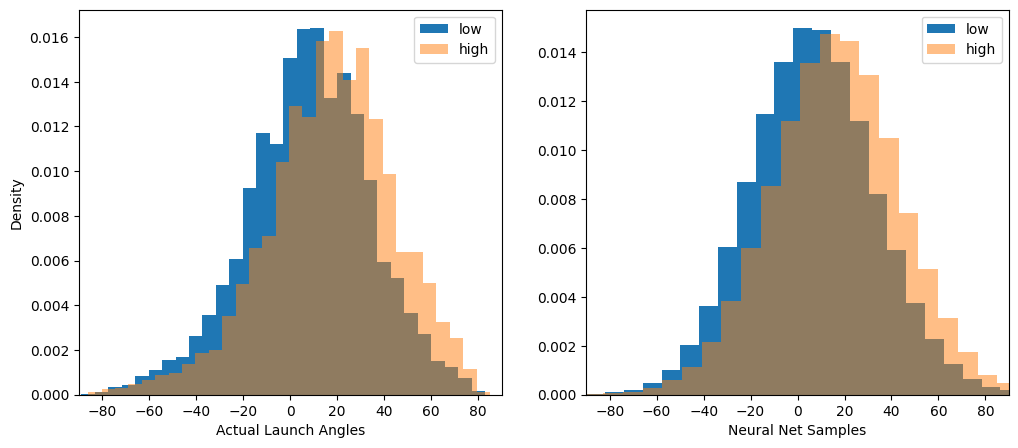

In [26]:
#pot without bayesian model
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.hist(test.loc[test.is_high == 0].launch_angle.values, density = True, bins = 30, label = 'low')
ax1.hist(test.loc[test.is_high == 1].launch_angle.values, density = True, bins = 30, label = 'high', alpha = 0.5)
ax1.legend()
ax1.set_xlim((-90,90))
ax1.set_xlabel('Actual Launch Angles')
ax1.set_ylabel('Density')

ax2 = plt.subplot(122)
ax2.hist(test.loc[test.is_high == 0].samples.values, density = True, bins = 30, label = 'low')
ax2.hist(test.loc[test.is_high == 1].samples.values, density = True, bins = 30, label = 'high', alpha = 0.5)
ax2.legend()
ax2.set_xlim((-90,90))
ax2.set_xlabel('Neural Net Samples')
plt.show()

Looks pretty clear in the previous two cells that the neural net does a better job of getting the different effects of high and low pitches on launch angle.

In [27]:
#individual hitters
#combine test and train so we have plenty of data for each individual
df = pd.concat((train, test))

#lowe
hitter = df.loc[df.batter == 663993]

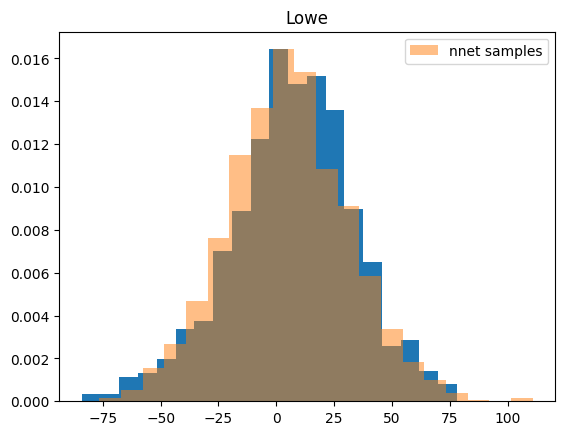

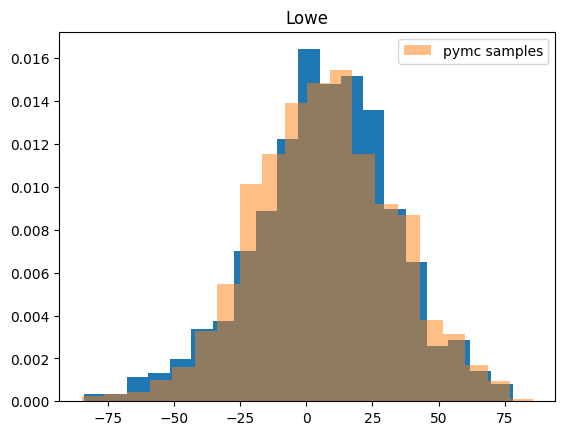

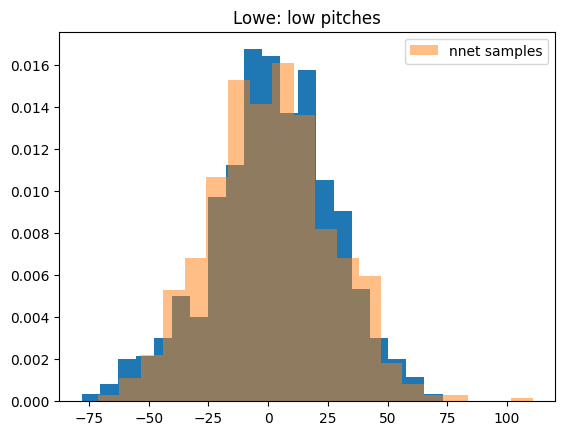

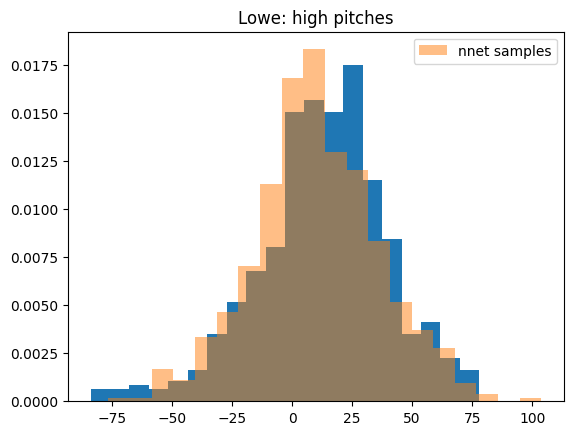

In [28]:
plt.hist(hitter.launch_angle.values, density = True, bins = 20)
plt.hist(hitter.samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Lowe')
plt.show()

plt.hist(hitter.launch_angle.values, density = True, bins = 20)
plt.hist(hitter.old_samples.values, density = True, bins = 20, label = 'pymc samples', alpha = 0.5)
plt.legend()
plt.title('Lowe')
plt.show()

plt.hist(hitter.loc[hitter.is_high == 0].launch_angle.values, density = True, bins = 20)
plt.hist(hitter.loc[hitter.is_high == 0].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Lowe: low pitches')
plt.show()


plt.hist(hitter.loc[hitter.is_high == 1].launch_angle.values, density = True, bins = 20)
plt.hist(hitter.loc[hitter.is_high == 1].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Lowe: high pitches')
plt.show()

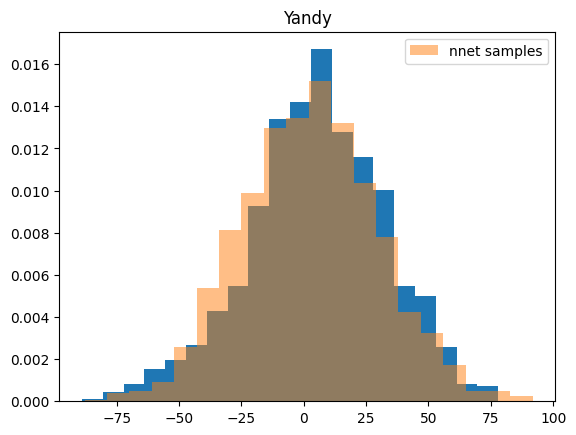

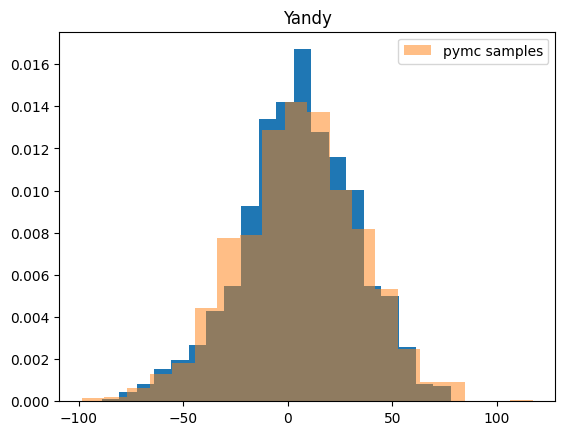

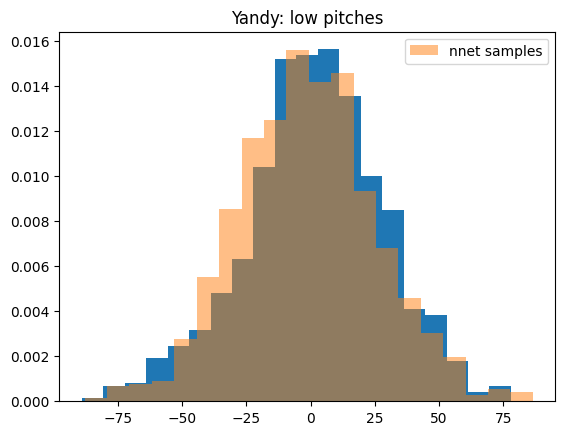

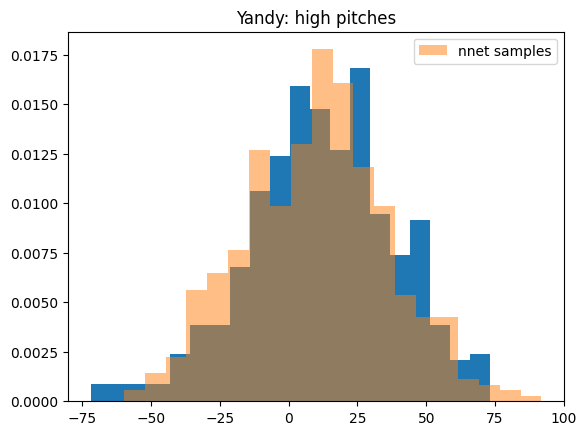

In [29]:
#yandy diaz: more of a groundball hitter
hitter2 = df.loc[df.batter == 650490]
plt.hist(hitter2.launch_angle.values, density = True, bins = 20)
plt.hist(hitter2.samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Yandy')
plt.show()

plt.hist(hitter2.launch_angle.values, density = True, bins = 20)
plt.hist(hitter2.old_samples.values, density = True, bins = 20, label = 'pymc samples', alpha = 0.5)
plt.legend()
plt.title('Yandy')
plt.show()

plt.hist(hitter2.loc[hitter2.is_high == 0].launch_angle.values, density = True, bins = 20)
plt.hist(hitter2.loc[hitter2.is_high == 0].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Yandy: low pitches')
plt.show()


plt.hist(hitter2.loc[hitter2.is_high == 1].launch_angle.values, density = True, bins = 20)
plt.hist(hitter2.loc[hitter2.is_high == 1].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Yandy: high pitches')
plt.show()

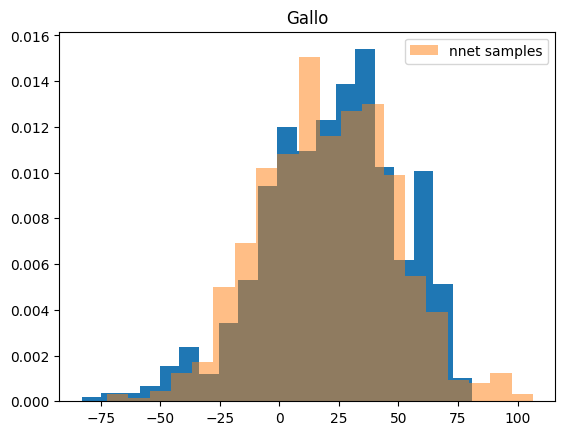

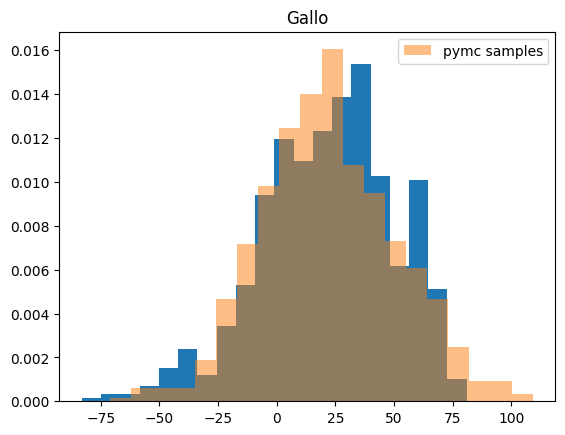

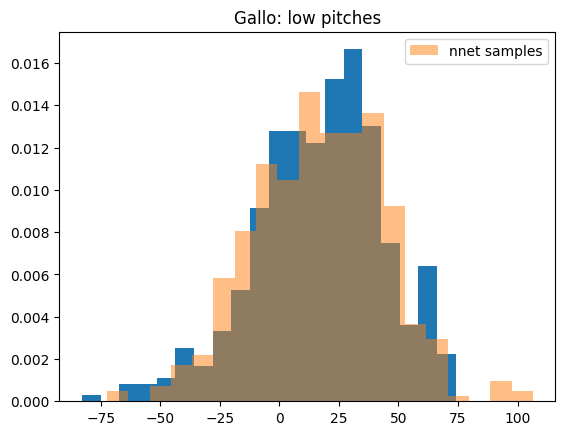

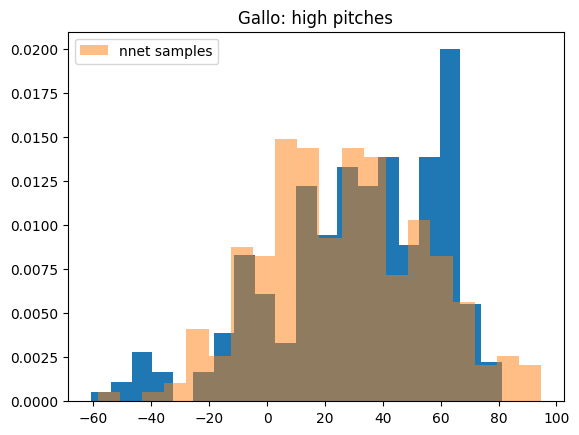

In [30]:
#gallo: high launch angle hitter
hitter3 = df.loc[df.batter == 608336]
plt.hist(hitter3.launch_angle.values, density = True, bins = 20)
plt.hist(hitter3.samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Gallo')
plt.show()

plt.hist(hitter3.launch_angle.values, density = True, bins = 20)
plt.hist(hitter3.old_samples.values, density = True, bins = 20, label = 'pymc samples', alpha = 0.5)
plt.legend()
plt.title('Gallo')
plt.show()

plt.hist(hitter3.loc[hitter3.is_high == 0].launch_angle.values, density = True, bins = 20)
plt.hist(hitter3.loc[hitter3.is_high == 0].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Gallo: low pitches')
plt.show()


plt.hist(hitter3.loc[hitter3.is_high == 1].launch_angle.values, density = True, bins = 20)
plt.hist(hitter3.loc[hitter3.is_high == 1].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Gallo: high pitches')
plt.show()

Based on the Gallo plots, it looks to me like the neural net may be underfitting batter just slightly, but pymc was also a little low for gallo so maybe it's as good as it gets.

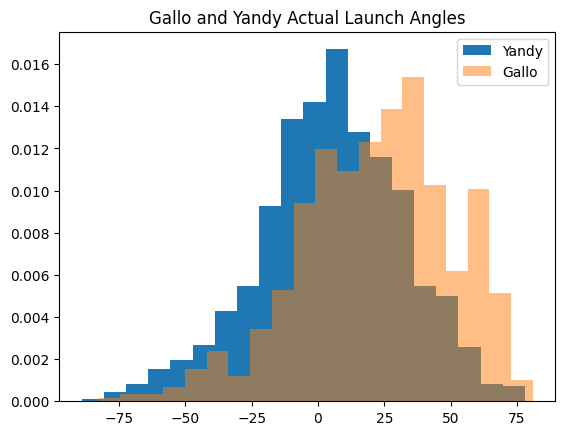

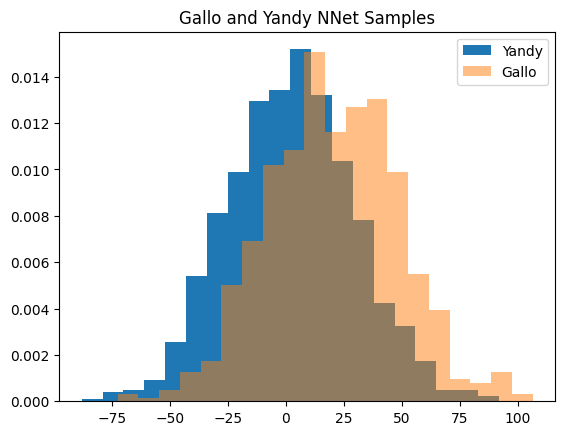

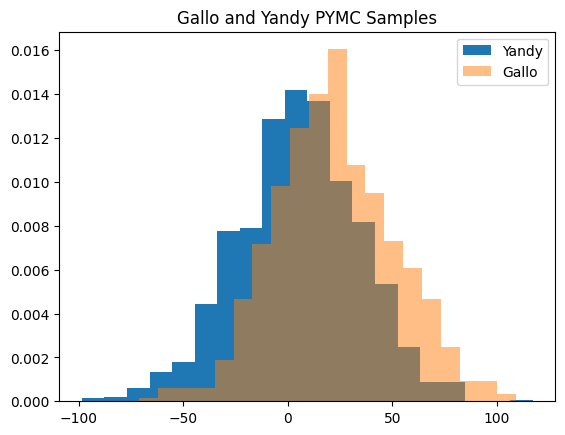

In [31]:
plt.hist(hitter2.launch_angle.values, density = True, bins = 20, label = 'Yandy')
plt.hist(hitter3.launch_angle.values, density = True, bins = 20, label = 'Gallo', alpha = 0.5)
plt.legend()
plt.title('Gallo and Yandy Actual Launch Angles')
plt.show()

plt.hist(hitter2.samples.values, density = True, bins = 20, label = 'Yandy')
plt.hist(hitter3.samples.values, density = True, bins = 20, label = 'Gallo', alpha = 0.5)
plt.legend()
plt.title('Gallo and Yandy NNet Samples')
plt.show()

plt.hist(hitter2.old_samples.values, density = True, bins = 20, label = 'Yandy')
plt.hist(hitter3.old_samples.values, density = True, bins = 20, label = 'Gallo', alpha = 0.5)
plt.legend()
plt.title('Gallo and Yandy PYMC Samples')
plt.show()

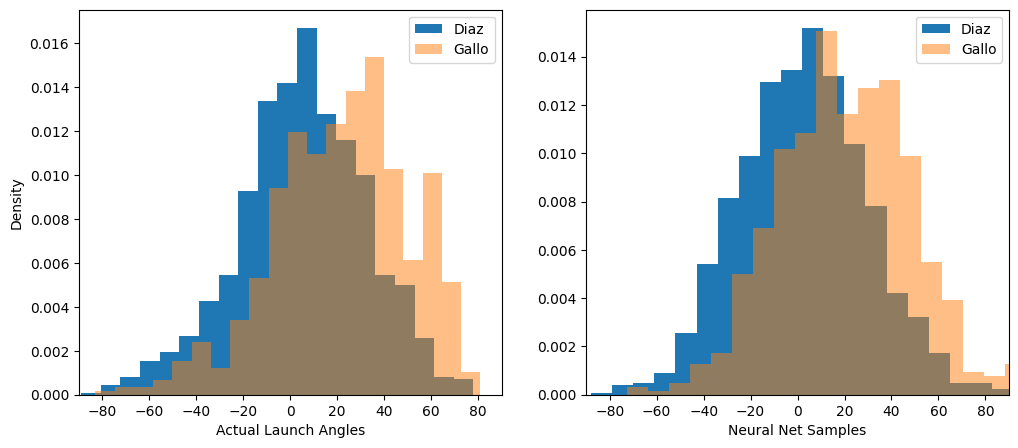

In [32]:
#prettier plot for paper
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.hist(hitter2.launch_angle.values, density = True, bins = 20, label = 'Diaz')
ax1.hist(hitter3.launch_angle.values, density = True, bins = 20, label = 'Gallo', alpha = 0.5)
ax1.legend()
ax1.set_xlim((-90,90))
ax1.set_xlabel('Actual Launch Angles')
ax1.set_ylabel('Density')

ax2 = plt.subplot(122)
ax2.hist(hitter2.samples.values, density = True, bins = 20, label = 'Diaz')
ax2.hist(hitter3.samples.values, density = True, bins = 20, label = 'Gallo', alpha = 0.5)
ax2.legend()
ax2.set_xlim((-90,90))
ax2.set_xlabel('Neural Net Samples')
plt.show()

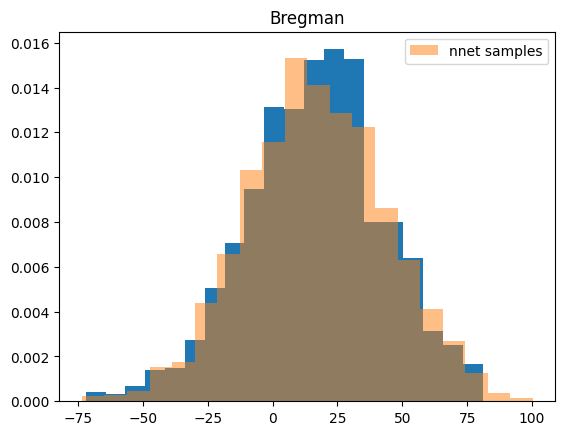

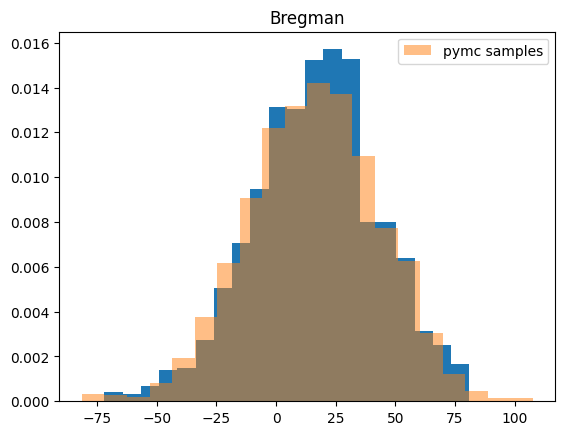

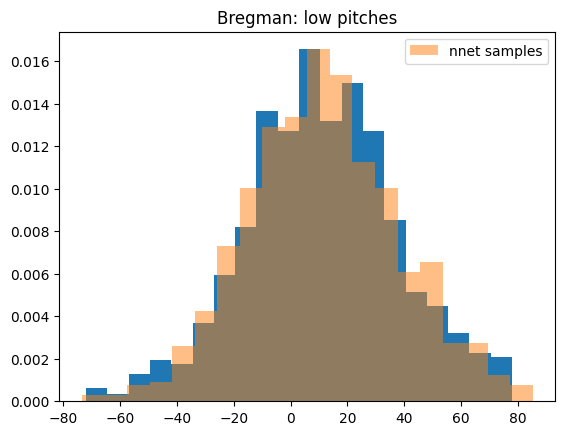

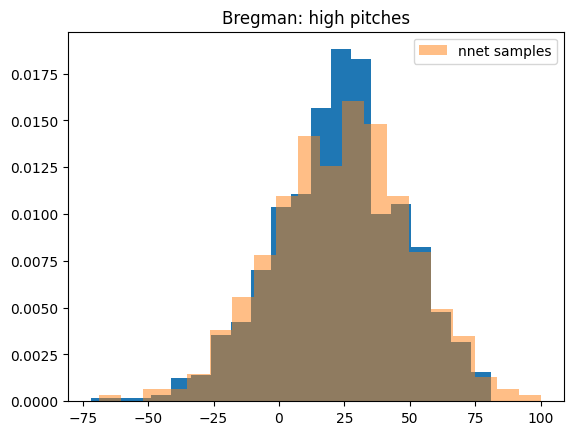

In [ ]:
#Bregman
hitter = df.loc[df.batter == 608324]
plt.hist(hitter.launch_angle.values, density = True, bins = 20)
plt.hist(hitter.samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Bregman')
plt.show()

plt.hist(hitter.launch_angle.values, density = True, bins = 20)
plt.hist(hitter.old_samples.values, density = True, bins = 20, label = 'pymc samples', alpha = 0.5)
plt.legend()
plt.title('Bregman')
plt.show()

plt.hist(hitter.loc[hitter.is_high == 0].launch_angle.values, density = True, bins = 20)
plt.hist(hitter.loc[hitter.is_high == 0].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Bregman: low pitches')
plt.show()


plt.hist(hitter.loc[hitter.is_high == 1].launch_angle.values, density = True, bins = 20)
plt.hist(hitter.loc[hitter.is_high == 1].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('Bregman: high pitches')
plt.show()

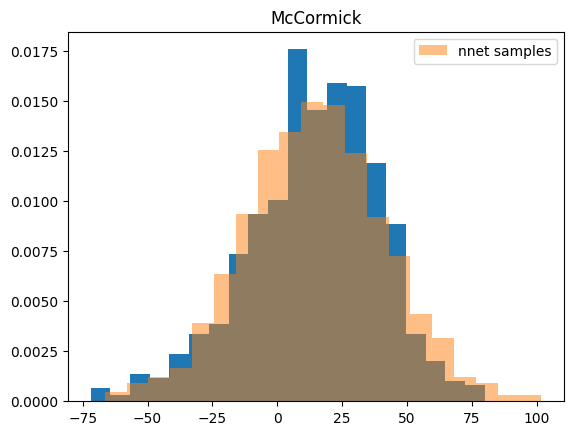

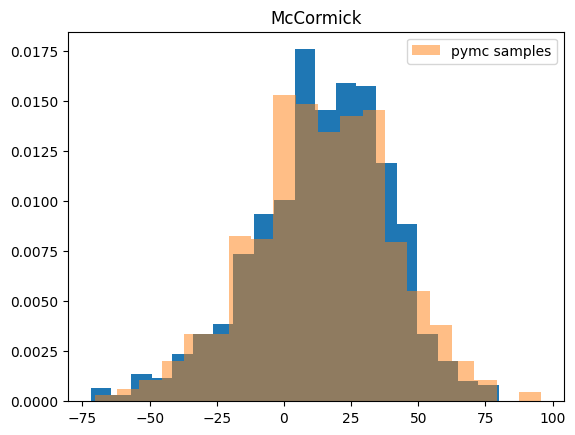

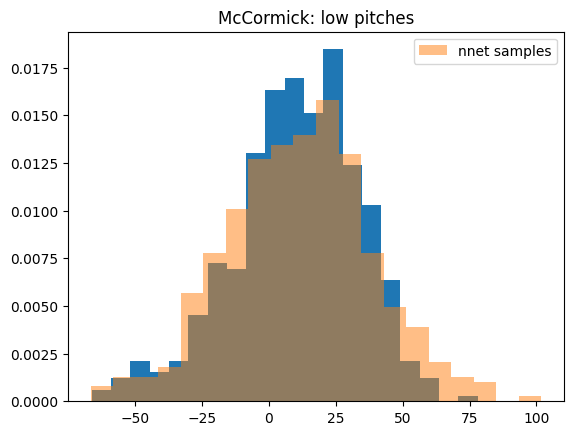

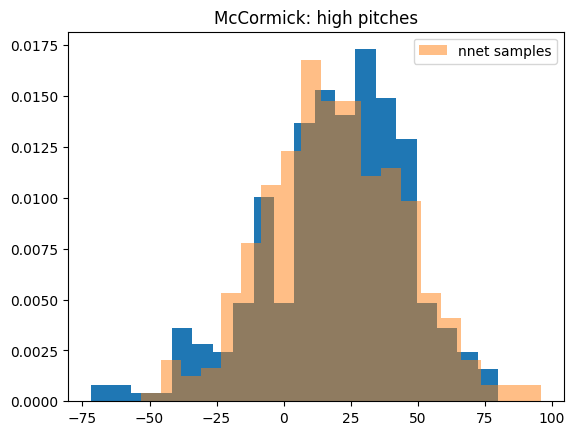

In [ ]:
#McCormick
hitter = df.loc[df.batter == 676801]
plt.hist(hitter.launch_angle.values, density = True, bins = 20)
plt.hist(hitter.samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('McCormick')
plt.show()

plt.hist(hitter.launch_angle.values, density = True, bins = 20)
plt.hist(hitter.old_samples.values, density = True, bins = 20, label = 'pymc samples', alpha = 0.5)
plt.legend()
plt.title('McCormick')
plt.show()

plt.hist(hitter.loc[hitter.is_high == 0].launch_angle.values, density = True, bins = 20)
plt.hist(hitter.loc[hitter.is_high == 0].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('McCormick: low pitches')
plt.show()


plt.hist(hitter.loc[hitter.is_high == 1].launch_angle.values, density = True, bins = 20)
plt.hist(hitter.loc[hitter.is_high == 1].samples.values, density = True, bins = 20, label = 'nnet samples', alpha = 0.5)
plt.legend()
plt.title('McCormick: high pitches')
plt.show()

Everything looks good.